In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Carregar o dataset
df = pd.read_csv('processed_data/art_prices_clean.csv')
# Verificar as primeiras linhas
print(df.head())

   index  is_signed  is_numbered  condition_score  price_clean  year_clean  \
0      0          1            0                3      28500.0      2021.0   
1      1          1            0                1       3000.0      1950.0   
2      2          1            0                3       5000.0      2016.0   
3      3          1            0                3       5000.0      2010.0   
4      4          1            0                3       2500.0      2001.0   

       period_clean  period_contemporary  period_mid-20th_century  \
0      Contemporary                    1                        0   
1  Mid-20th Century                    0                        1   
2      Contemporary                    1                        0   
3      Contemporary                    1                        0   
4      Contemporary                    1                        0   

   period_early-20th_century  ... movement_group movement_abstract  \
0                          0  ...          Oth


Valores faltantes antes do tratamento:
is_signed                     0
is_numbered                   0
condition_score               0
year_clean                   20
period_clean                  0
period_contemporary           0
period_mid-20th_century       0
period_early-20th_century     0
movement_clean                0
movement_group                0
movement_abstract             0
movement_realism              0
movement_expressionism        0
movement_pop_art              0
movement_conceptual_          0
movement_other                0
movement_surrealism           0
movement_impressionism        0
movement_minimalism           0
dtype: int64

Métricas de Performance:
R² Score: 0.060
RMSE: 14901.10

Top 10 Features Mais Importantes:
                              Feature  Coefficient  Absolute_Impact
movement_clean_Abstract Expressionism  7585.443817      7585.443817
        period_clean_Pre-20th Century  7080.254118      7080.254118
                   period_clean_[nan] -6038

/tmp/ipykernel_143537/3381446718.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Absolute_Impact', y='Feature',


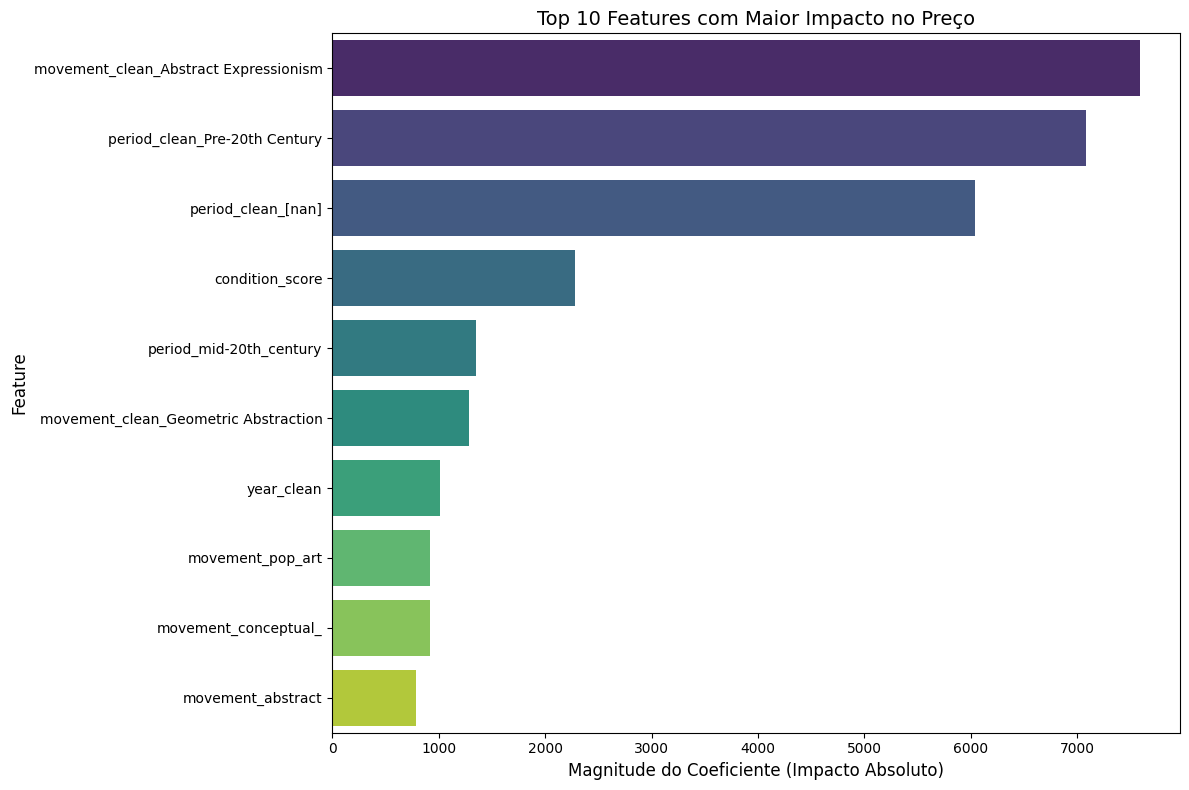

In [ ]:
# 2. Preparar os dados
X = df.drop(columns=['price_clean', 'index'])
y = df['price_clean']

# 3. Tratar valores faltantes
print("\nValores faltantes antes do tratamento:")
print(X.isna().sum())

# Preencher numéricos com mediana e categóricos com moda
numeric_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(exclude=np.number).columns

imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

X[numeric_cols] = imputer_num.fit_transform(X[numeric_cols])
X[categorical_cols] = imputer_cat.fit_transform(X[categorical_cols])

# 4. Codificação de variáveis categóricas
X = pd.get_dummies(X, drop_first=True)

# 5. Normalização dos dados numéricos
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# 6. Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 7. Modelagem
model = LinearRegression()
model.fit(X_train, y_train)

# 8. Avaliação
y_pred = model.predict(X_test)

# Cálculo do RMSE corrigido
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nMétricas de Performance:")
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {rmse:.2f}")

# 9. Análise de importância
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_,
    'Absolute_Impact': abs(model.coef_)
}).sort_values('Absolute_Impact', ascending=False)

print("\nTop 10 Features Mais Importantes:")
print(importance.head(10).to_string(index=False))

# 10. Visualização
plt.figure(figsize=(12, 8))
sns.barplot(x='Absolute_Impact', y='Feature',
            data=importance.head(10), palette='viridis')
plt.title('Top 10 Features com Maior Impacto no Preço', fontsize=14)
plt.xlabel('Magnitude do Coeficiente (Impacto Absoluto)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()


Comparação de Modelos:
                      RMSE        R2 CV_R2_mean CV_R2_std
Linear        15436.975497  -0.00908  -5.830197  6.865098
Lasso         15469.246926 -0.013303  -5.627656  6.614903
Ridge         15444.600421 -0.010077  -5.814204  6.837466
RandomForest  15332.746814  0.004501  -2.788869  3.080924

Melhor modelo: RandomForest

Top 10 Features Mais Importantes:
                             Feature  Importance
                     condition_score    0.408357
                          year_clean    0.332636
                         is_numbered    0.032702
                   movement_abstract    0.020318
                 period_contemporary    0.013976
                      movement_other    0.012572
movement_clean_Geometric Abstraction    0.012018
                movement_group_Other    0.011249
              movement_group_Realism    0.010238
                movement_conceptual_    0.010116


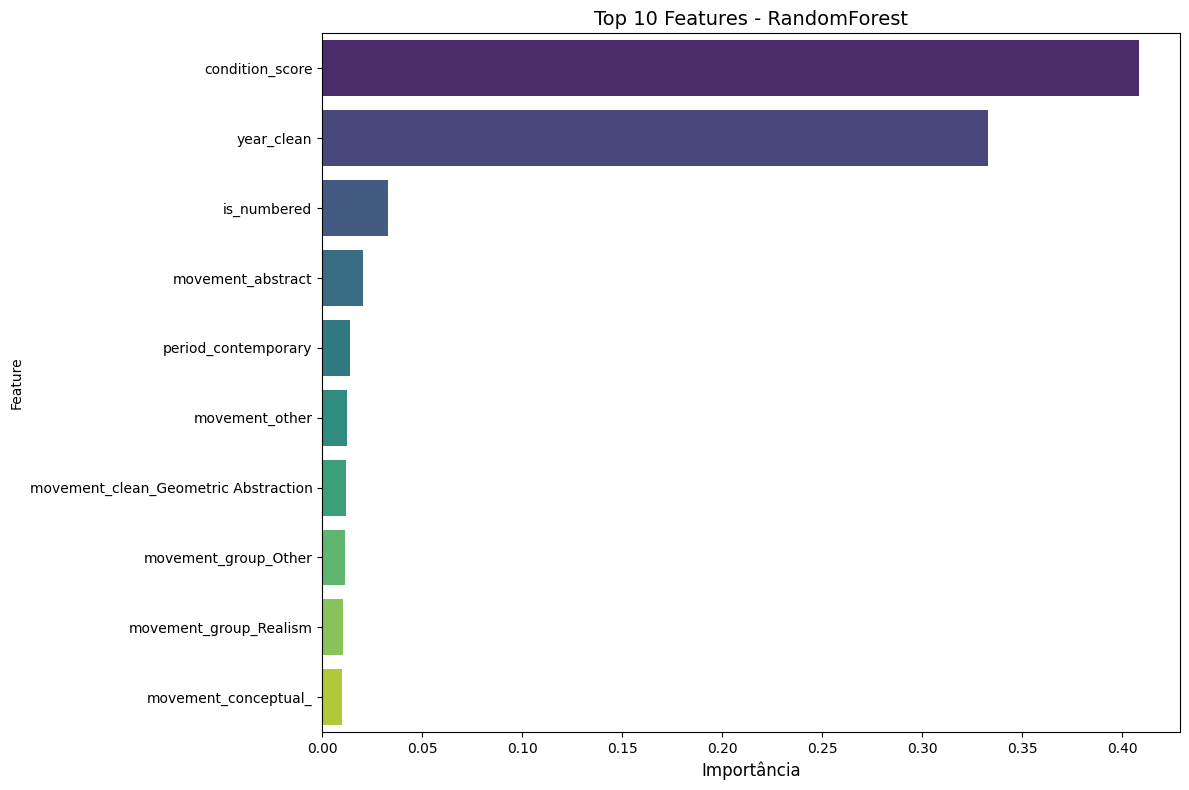

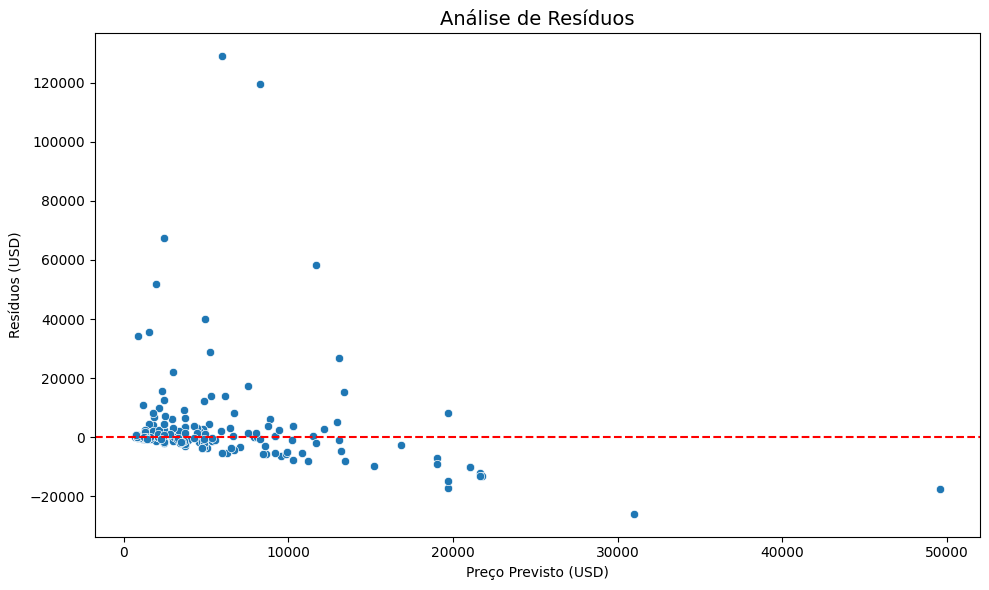


Melhor modelo salvo como 'best_art_price_model.pkl'


In [ ]:
# Codificação e normalização
X = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Transformação logarítmica do target
y_log = np.log1p(y)

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_log, test_size=0.3, random_state=42
)

# Modelagem com validação cruzada
models = {
    'Linear': LinearRegression(),
    'Lasso': LassoCV(cv=5),
    'Ridge': RidgeCV(cv=5),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    # Treinar modelo
    model.fit(X_train, y_train)

    # Prever e converter de volta para escala original
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_test_orig = np.expm1(y_test)

    # Métricas
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
    r2 = r2_score(y_test_orig, y_pred)

    # Cross-validation
    cv_scores = cross_val_score(model, X_scaled, y_log, cv=5, scoring='r2')

    results[name] = {
        'RMSE': rmse,
        'R2': r2,
        'CV_R2_mean': cv_scores.mean(),
        'CV_R2_std': cv_scores.std(),
        'model': model
    }

# Análise comparativa
results_df = pd.DataFrame(results).T
print("\nComparação de Modelos:")
print(results_df[['RMSE', 'R2', 'CV_R2_mean', 'CV_R2_std']])

# Análise do melhor modelo
best_model_name = results_df['R2'].idxmax()
best_model = results[best_model_name]['model']
print(f"\nMelhor modelo: {best_model_name}")

# Feature Importance
if hasattr(best_model, 'coef_'):
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': best_model.coef_,
        'Absolute_Impact': np.abs(best_model.coef_)
    }).sort_values('Absolute_Impact', ascending=False)
else:
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

print("\nTop 10 Features Mais Importantes:")
print(importance.head(10).to_string(index=False))

# Visualização
plt.figure(figsize=(12, 8))
sns.barplot(x=importance.head(10)['Absolute_Impact' if 'Absolute_Impact' in importance.columns else 'Importance'],
            y=importance.head(10)['Feature'],
            hue=importance.head(10)['Feature'],
            palette='viridis', legend=False)
plt.title(f'Top 10 Features - {best_model_name}', fontsize=14)
plt.xlabel('Importância' if 'Importance' in importance.columns else 'Magnitude do Coeficiente', fontsize=12)
plt.tight_layout()
plt.show()

# Análise de Resíduos
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
residuals = np.expm1(y_test) - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Análise de Resíduos', fontsize=14)
plt.xlabel('Preço Previsto (USD)')
plt.ylabel('Resíduos (USD)')
plt.tight_layout()
plt.show()

# Salvar o melhor modelo
import joblib
joblib.dump(best_model, 'best_art_price_model.pkl')
print("\nMelhor modelo salvo como 'best_art_price_model.pkl'")